This file is to recreate the results of a model by Srimanta Singha that achieved a score of 91-96% submitted to Kaggle. We will then take this same model and test it against our own dataset of AI generated images to see if this model was future-proof against today's AI generative models. 

Link: https://www.kaggle.com/code/srimantasingha/deepfakeimagedetection-96-91

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch tools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models, Module
from torchsummary import summary
from torchview import draw_graph

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# opencv tools
import cv2

In [11]:
g_train = {"fake": [], "real": []}
g_test  = {"fake": [], "real": []}

# Base directories
base_dirs = [
    "archive/train-20250112T065955Z-001",
    "archive/test-20250112T065939Z-001"
]

# Labels
labels = ["fake", "real"]

# Read the images
for base_dir in base_dirs:
    for label in labels:
        # Construct the image directory path
        img_dir = os.path.join(base_dir, "train" if "train" in base_dir else "test", label)
        
        # List all files in the directory and construct full paths
        files = [os.path.join(img_dir, x) for x in os.listdir(img_dir)]
        
        # Append files to the appropriate dictionary
        if "train" in base_dir:
            g_train[label] += files
        else:
            g_test[label] += files
print("Done!")

Done!


In [12]:
all_images = []
all_labels = []
for label in labels:
    all_images += g_train[label] + g_test[label]
    all_labels += [label]*len(g_train[label]) + [label]*len(g_test[label])

print("Done!")

Done!


In [13]:
data = pd.DataFrame({"images": all_images, "labels":all_labels})
display(data)

images labels
0    archive/train-20250112T065955Z-001\train\fake\...   fake
1    archive/train-20250112T065955Z-001\train\fake\...   fake
2    archive/train-20250112T065955Z-001\train\fake\...   fake
3    archive/train-20250112T065955Z-001\train\fake\...   fake
4    archive/train-20250112T065955Z-001\train\fake\...   fake
..                                                 ...    ...
973  archive/test-20250112T065939Z-001\test\real\51...   real
974  archive/test-20250112T065939Z-001\test\real\51...   real
975  archive/test-20250112T065939Z-001\test\real\51...   real
976  archive/test-20250112T065939Z-001\test\real\51...   real
977  archive/test-20250112T065939Z-001\test\real\51...   real

[978 rows x 2 columns]

In [14]:
data = data.sample(frac=1, random_state=42)  # Shuffle in place
data.reset_index(drop=True, inplace=True)  # Reset index in place

# Display the shuffled DataFrame
display(data)

images labels
0    archive/test-20250112T065939Z-001\test\fake\24...   fake
1    archive/train-20250112T065955Z-001\train\real\...   real
2    archive/test-20250112T065939Z-001\test\fake\11...   fake
3    archive/test-20250112T065939Z-001\test\real\50...   real
4    archive/train-20250112T065955Z-001\train\fake\...   fake
..                                                 ...    ...
973  archive/train-20250112T065955Z-001\train\fake\...   fake
974  archive/test-20250112T065939Z-001\test\fake\31...   fake
975  archive/train-20250112T065955Z-001\train\real\...   real
976  archive/test-20250112T065939Z-001\test\fake\46...   fake
977  archive/train-20250112T065955Z-001\train\fake\...   fake

[978 rows x 2 columns]

In [15]:
# convert the labels into numeric formate
label_map = {'fake': 0, 'real':1}
# apply into the table
data['labels'] = data['labels'].map(label_map)
# Display the updated DataFrame
display(data)

images  labels
0    archive/test-20250112T065939Z-001\test\fake\24...       0
1    archive/train-20250112T065955Z-001\train\real\...       1
2    archive/test-20250112T065939Z-001\test\fake\11...       0
3    archive/test-20250112T065939Z-001\test\real\50...       1
4    archive/train-20250112T065955Z-001\train\fake\...       0
..                                                 ...     ...
973  archive/train-20250112T065955Z-001\train\fake\...       0
974  archive/test-20250112T065939Z-001\test\fake\31...       0
975  archive/train-20250112T065955Z-001\train\real\...       1
976  archive/test-20250112T065939Z-001\test\fake\46...       0
977  archive/train-20250112T065955Z-001\train\fake\...       0

[978 rows x 2 columns]

In [16]:
Images = []
Labels = []
# height and weidth
max_height = float('-inf')
min_height = float('inf')
max_weidth = float('-inf')
min_weidth = float('inf')
for i in range(len(data)):
    image_path = data['images'][i]
    label = data['labels'][i]
    try:
        # read images 
        img = cv2.imread(image_path)
        # convert BGR  to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is None:
           raise FileNotFoundError("Image not found or unable to read the file.")
        Images.append(img)
        Labels.append(label)
        max_height = max(max_height, img.shape[0])
        min_height = min(min_height, img.shape[0])
        max_weidth = max(max_weidth, img.shape[1])
        min_weidth  = min(min_weidth, img.shape[1])
    except Exception as e:
        print("An unexpected error occurred:", e)

print(f"Max Height: {max_height}")
print(f"Min Height: {min_height}")

print(f"Max Weidth: {max_weidth}")
print(f"Min Weidth: {min_weidth}")

Max Height: 7091
Min Height: 135
Max Weidth: 8495
Min Weidth: 183


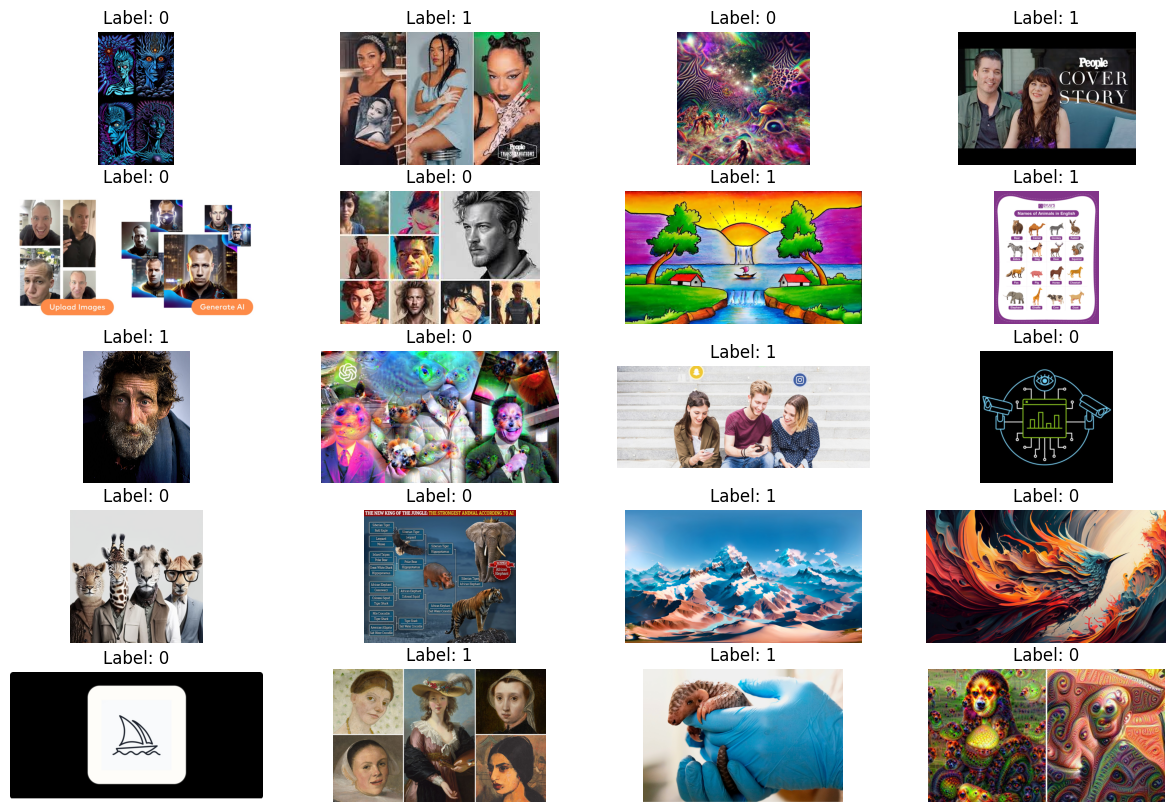

In [17]:
# Visualize some images
# number of images
num_imgs = 20
ncols = 4
nrows = (num_imgs + ncols - 1) // ncols
# Create a figure to display the images
plt.figure(figsize=(15, 10))
for i, img in enumerate(Images[:num_imgs]):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.title(f"Label: {Labels[i]}")
    plt.axis('off')
plt.show()

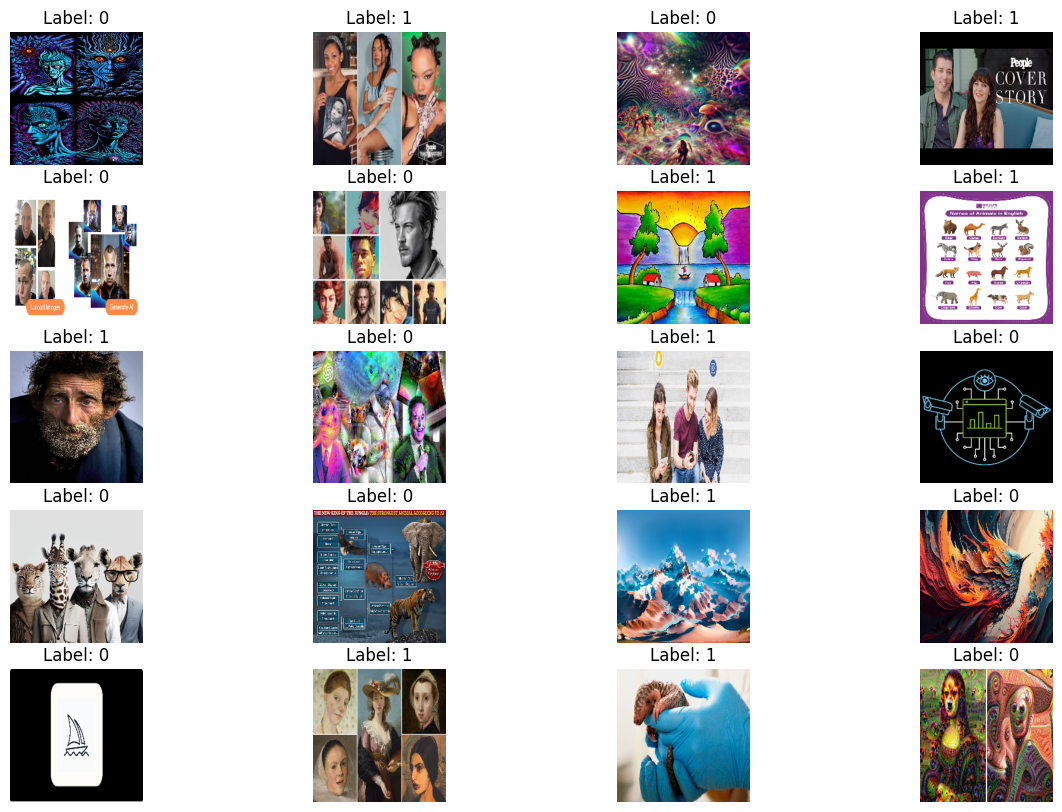

In [18]:
# resize the images
target_size = (224,224)
Images_resize = [cv2.resize(img, target_size) for img in Images]

# Visualize some images
# number of images
num_imgs = 20
ncols = 4
nrows = (num_imgs + ncols - 1) // ncols
# Create a figure to display the images
plt.figure(figsize=(15, 10))
for i, img in enumerate(Images_resize[:num_imgs]):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.title(f"Label: {Labels[i]}")
    plt.axis('off')
plt.show()

In [19]:
# Step 1: Split into 95% training and 5% testing
X_train, X_test, y_train, y_test = train_test_split(Images_resize, Labels, test_size=0.05, random_state=42)

# Step 2: Split the training set into 95% training and 5% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

# Step 5: Verify the shapes of the generators
print("Training data shape:", len(X_train))
print("Validation data shape:", len(X_val))
print("Testing data shape:", len(X_test))

Training data shape: 882
Validation data shape: 47
Testing data shape: 49


In [20]:
# Define Transformations: Augment First, Then Normalize
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert OpenCV (NumPy) image to PIL format
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert to Tensor [0,1], normalized pixel
])

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: List of NumPy arrays (H, W, C) 
        labels: List or NumPy array of shape (N,)
        transform: Augmentation transformations
        """
        self.images = np.array(images)  # Keep as NumPy array, apply transforms later
        self.labels = torch.tensor(np.array(labels), dtype=torch.long)
        self.transform = transform  # Store the transform function

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)  # Apply augmentations

        label = self.labels[idx]
        return image, label

# Create dataset and DataLoader
train_dataset = CustomImageDataset(X_train, y_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = CustomImageDataset(X_val, y_val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [21]:
# Fetch one batch
images, labels = next(iter(train_dataloader))
print(images.shape)  # Expected: [batch_size, 3, H, W]
print(labels)

torch.Size([64, 3, 224, 224])
tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0])


**Model Training**

In [22]:
# Load the pretrained model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze all layers except the last ones
for param in model.parameters():
    param.requires_grad = False  # Unfreeze all layers

# Modify the fully connected (FC) layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),  # First fully connected layer
    nn.BatchNorm1d(1024),       # Batch Normalization
    nn.LeakyReLU(),             # Activation function
    nn.Dropout(0.5),            # Dropout for regularization
    
    nn.Linear(1024, 512),       # Second fully connected layer
    nn.BatchNorm1d(512),        # Batch Normalization
    nn.LeakyReLU(),             # Activation function
    nn.Dropout(0.5),            # Dropout for regularization
    
    nn.Linear(512, 1),          # Final fully connected layer
    nn.Sigmoid()                # Sigmoid activation for binary classification
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\alexm/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|███████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:09<00:00, 10.7MB/s]


device = cpu


In [23]:
# Define Loss Function & Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define Accuracy Function
def binary_accuracy(preds, labels):
    preds = (preds >= 0.5).float()  # Convert probabilities to binary (0 or 1)
    return (preds == labels).sum().item() / labels.size(0)

# Adaptive Learning Rate Scheduler (Reduce LR if val_loss does not improve for 3 epochs)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Training Function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, save_path="best_model.pth"):
    best_val_loss = float('inf') 
    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Ensure labels are float

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += binary_accuracy(outputs, labels)

        # Validation
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_acc += binary_accuracy(outputs, labels)
        # Reduce LR if validation loss does not improve
        scheduler.step(val_loss)

        # Save Best Model (Based on Validation Loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"Saving the Model with loss{best_val_loss}")
            torch.save(model.state_dict(), save_path)
        # Get the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        # Print Training and Validation Metrics
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc/len(train_loader):.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc/len(val_loader):.4f}|",
              f"LR:{current_lr:.6f} ")

In [24]:
# training 
train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epochs=100, save_path="best_resnet50.pth")

Saving the Model with loss0.685448408126831
Epoch 1/100 | Train Loss: 0.6503, Train Acc: 0.6179 | Val Loss: 0.6854, Val Acc: 0.5532| LR:0.000100 
Saving the Model with loss0.6703083515167236
Epoch 2/100 | Train Loss: 0.5536, Train Acc: 0.7180 | Val Loss: 0.6703, Val Acc: 0.5957| LR:0.000100 
Saving the Model with loss0.648602306842804
Epoch 3/100 | Train Loss: 0.4851, Train Acc: 0.7804 | Val Loss: 0.6486, Val Acc: 0.6596| LR:0.000100 
Saving the Model with loss0.6433958411216736
Epoch 4/100 | Train Loss: 0.4230, Train Acc: 0.8247 | Val Loss: 0.6434, Val Acc: 0.6170| LR:0.000100 
Epoch 5/100 | Train Loss: 0.3878, Train Acc: 0.8321 | Val Loss: 0.6560, Val Acc: 0.6383| LR:0.000100 
Epoch 6/100 | Train Loss: 0.3525, Train Acc: 0.8674 | Val Loss: 0.6574, Val Acc: 0.7234| LR:0.000100 
Saving the Model with loss0.6182692646980286
Epoch 7/100 | Train Loss: 0.3147, Train Acc: 0.8849 | Val Loss: 0.6183, Val Acc: 0.7234| LR:0.000100 
Epoch 8/100 | Train Loss: 0.2833, Train Acc: 0.9069 | Val Loss:

In [26]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert OpenCV (NumPy) image to PIL format
    transforms.ToTensor(),  # Convert to Tensor [0,1], normalized pixel
])
test_dataset = CustomImageDataset(X_test, y_test, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False)
# Validation
model.eval()
val_acc = 0.0
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        val_acc += binary_accuracy(outputs, labels)
print(f"Test Accuracy: {val_acc}")

Test Accuracy: 0.7959183673469388


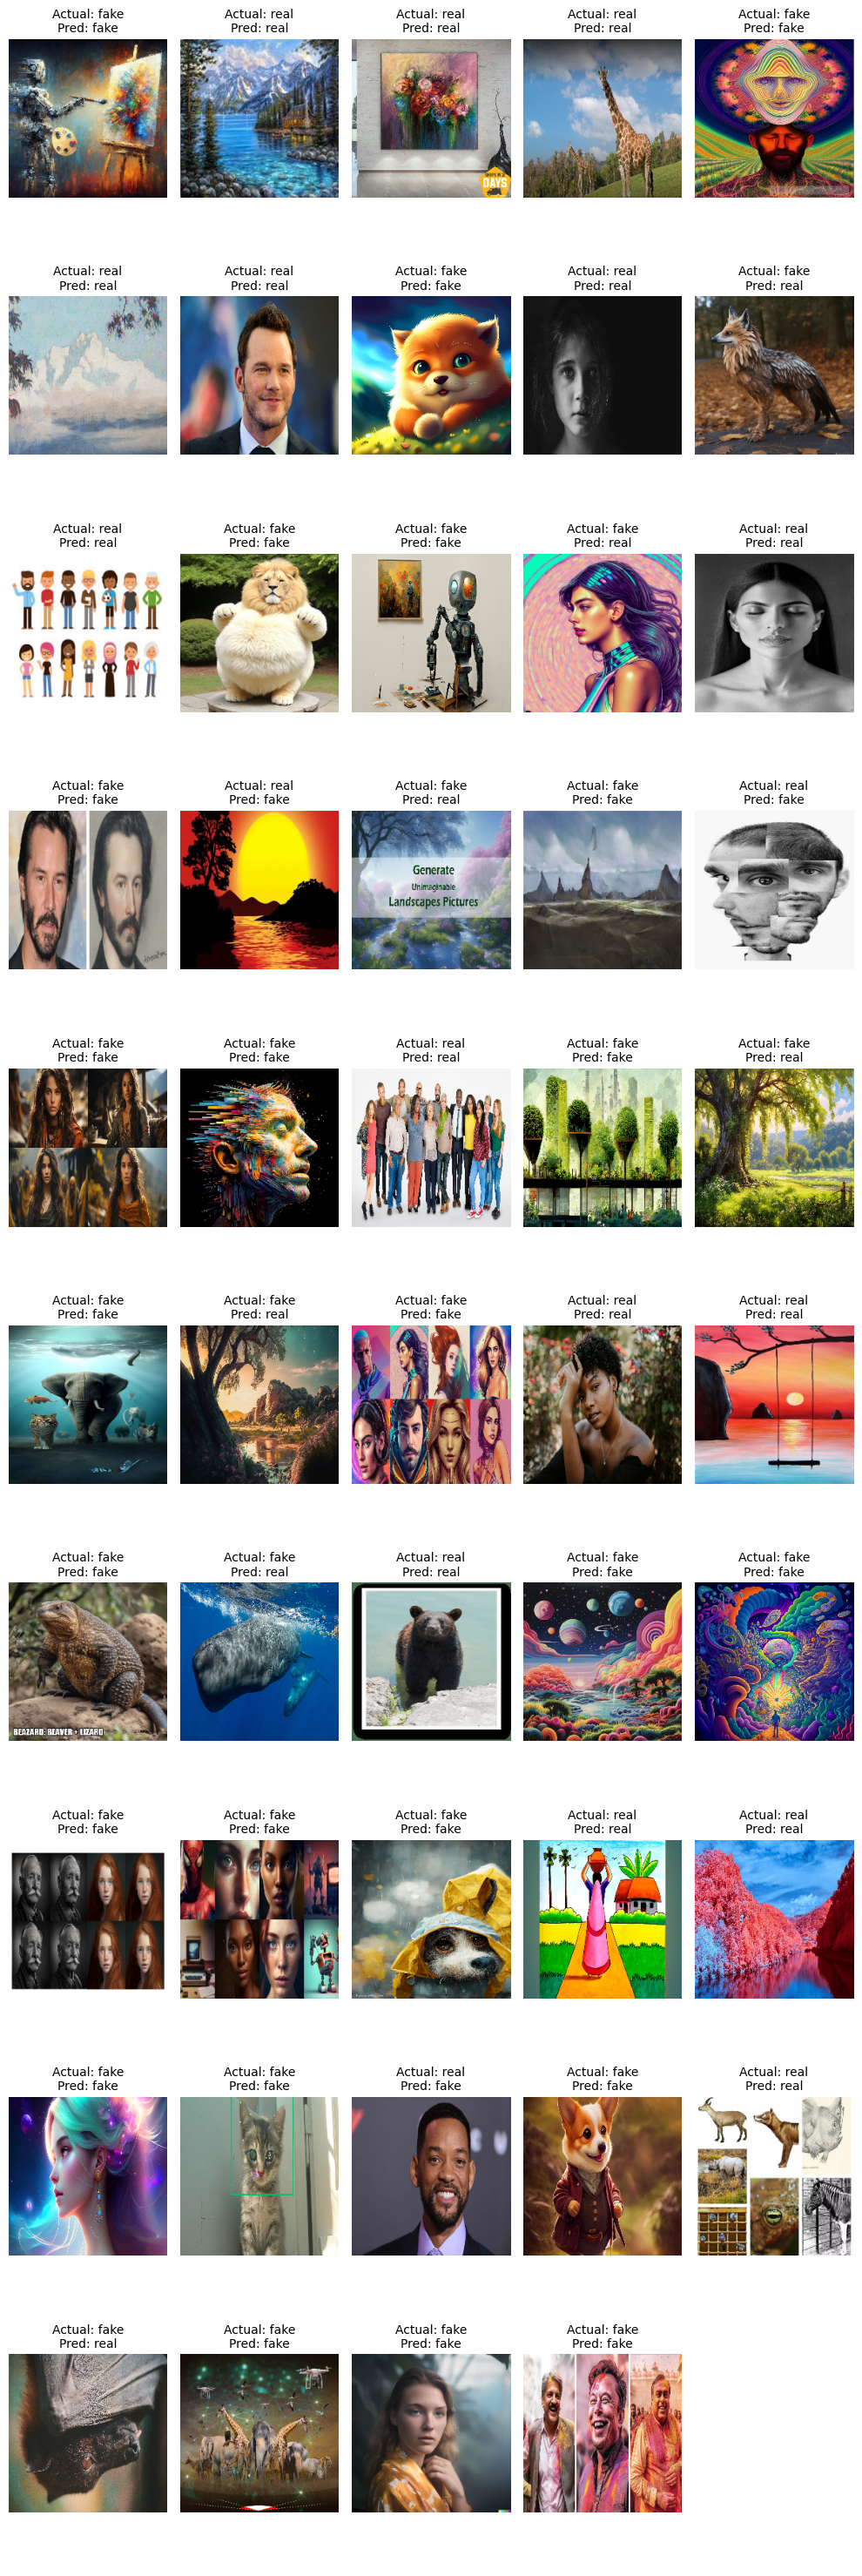

In [27]:
def plot_test_images(image_list, labels, preds, class_names, num_images=10):
    """
    image_list: List of test images (NumPy arrays in [H, W, C] format).
    labels: List or array of actual labels.
    preds: List or array of predicted labels.
    class_names: Dictionary or list mapping label indices to class names.
    num_images: Number of images to display.
    """
    num_images = min(num_images, len(image_list))  # Ensure we don't exceed available images
    ncols = 5
    nrows = int(np.ceil(num_images / ncols))  # Round up rows to fit all images

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 30))
    axes = axes.flatten()
    
    for i in range(num_images):
        img = image_list[i]  # Get image
        actual_label = class_names[labels[i]]
        predicted_label = class_names[1 if preds[i] >= 0.5 else 0]
        axes[i].imshow(img)
        axes[i].set_title(f"Actual: {actual_label}\nPred: {predicted_label}", fontsize=10)
        axes[i].axis("off")
    # Hide unused subplots (if any)
    for i in range(num_images, len(axes)):  
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()
# Plot
plot_test_images(image_list=X_test,labels=y_test, preds=outputs, class_names={0: "fake", 1: "real"}, num_images=len(X_test))